In [1]:
from nbed.driver import NbedDriver
from nbed.ham_builder import HamiltonianBuilder
from openfermion import get_sparse_operator
import scipy as sp
from openfermion.utils import count_qubits
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from nbed.mol_plot import Draw_molecule
import pandas as pd
import pickle
from nbed.ham_converter import HamiltonianConverter

In [2]:
current_dir = os.getcwd()
structure_dir =  os.path.join(current_dir, "molecular_structures")

In [3]:
# order by R_length

list_files = [ filename for filename in os.listdir(structure_dir) if filename.startswith('act_stretch_H2O')]

all_xyz_files = sorted(list_files, 
                       key=lambda text: int(text.partition("H2O_")[2].partition(".xyz")[0]))
all_xyz_files

['act_stretch_H2O_40.xyz',
 'act_stretch_H2O_60.xyz',
 'act_stretch_H2O_79.xyz',
 'act_stretch_H2O_100.xyz',
 'act_stretch_H2O_120.xyz',
 'act_stretch_H2O_150.xyz',
 'act_stretch_H2O_200.xyz',
 'act_stretch_H2O_300.xyz',
 'act_stretch_H2O_400.xyz',
 'act_stretch_H2O_500.xyz']

In [5]:
list_file_paths = []
for xyz_filename in all_xyz_files:
    list_file_paths.append(os.path.join(structure_dir, xyz_filename))
list_file_paths

['/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_40.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_60.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_79.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_100.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_120.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_150.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_200.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_300.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_stretch_H2O_400.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_

In [6]:
with open(list_file_paths[0], 'r') as infile1:
    test_xyz = infile1.read()
    
print(test_xyz)

3
 
H	0.3751747	0.0	0.1387225
O	0.0	0.0	0.0
H	-0.7493682	0.0	0.2770822



In [11]:
basis = 'STO-3G'
xc_functional = 'B3LYP'
convergence = 1e-6
charge = 0
mu_level_shift=1e6
run_ccsd_emb = True
run_fci_emb = True
max_ram_memory = 8_000
pyscf_print_level = 1
unit = 'angstrom'


occupied_threshold = 0.90 # <---- CHANGED!
virtual_threshold = 0.95
max_hf_cycles=100_000
max_dft_cycles = 100_000
transform = 'jordan_wigner'

In [12]:
n_active_atoms = 2
localization = 'ibo' #ibo, spade

projector = 'both' #'both', 'huzinaga'
init_huzinaga_rhf_with_mu = True

In [13]:
def get_hamiltonian_from_driver(rhf_pyscf, energy_shift, qubit_transform):
    # n_qubits = 2*rhf_pyscf.mol.nao
    qham = HamiltonianBuilder(
                            scf_method=rhf_pyscf,
                            constant_e_shift=energy_shift,
                            transform=qubit_transform,
                            ).build(n_qubits=None, taper=False)
    return qham

In [14]:
global_dft_list=[]
global_fci_list=[]
global_H_diag_list=[]
global_qubit_H_length_list=[]
global_qubit_H_nqubits=[]
global_H = []

huz_rhf_list=[]
huz_ccsd_list=[]
huz_fci_list=[]
huz_H_diag_list=[]
huz_qubit_H_length_list=[]
huz_H_nqubits=[]
huz_embed_H = []

mu_rhf_list=[]
mu_ccsd_list=[]
mu_fci_list=[]
mu_H_diag_list=[]
mu_qubit_H_length_list=[]
mu_H_nqubits=[]
mu_embed_H = []

N_active_MOs = []

for geometry_path in tqdm(list_file_paths):
#     try:
    driver = NbedDriver(
            geometry=geometry_path,
            n_active_atoms=n_active_atoms,
            basis=basis,
            xc_functional=xc_functional,
            projector=projector,
            localization=localization,
            convergence=convergence,
            charge=charge,
            mu_level_shift=mu_level_shift,
            run_ccsd_emb=run_ccsd_emb,
            run_fci_emb=run_fci_emb,
            max_ram_memory=max_ram_memory,
            pyscf_print_level=pyscf_print_level,
            unit=unit,
            occupied_threshold=occupied_threshold,
            virtual_threshold=virtual_threshold,
            max_hf_cycles=max_hf_cycles,
            max_dft_cycles=max_dft_cycles,
            _init_huzinaga_rhf_with_mu = init_huzinaga_rhf_with_mu)
#     except:
#         print('error for:')
#         print(geometry_path)
#         print()
#         continue

    ## global
    global_dft_list.append(driver._global_rks.e_tot)
    global_fci_list.append(driver._global_fci.e_tot)
    
    global_qubit_Ham = get_hamiltonian_from_driver(driver._global_hf,
                                           driver._global_hf.energy_nuc(), 
                                           transform)
    
    global_H_sparse = get_sparse_operator(global_qubit_Ham)
    E_fci =  sp.sparse.linalg.eigsh(global_H_sparse, k=1, which='SA')[0][0] 
    global_H_diag_list.append(E_fci)

    global_qubit_H_length_list.append(len(global_qubit_Ham.terms))
    global_qubit_H_nqubits.append(count_qubits(global_qubit_Ham))
    global_H.append(global_qubit_Ham)

    ##
    N_active_MOs.append(len(driver.localized_system.active_MO_inds))
    
    # HUZ
    huz_rhf_list.append(driver._huzinaga['e_rhf'])
    huz_ccsd_list.append(driver._huzinaga['e_ccsd'])
    huz_fci_list.append(driver._huzinaga['e_fci'])

    huz_classical = driver._huzinaga['classical_energy']
    huz_qubit_Ham = get_hamiltonian_from_driver(driver._huzinaga["scf"],
                                        huz_classical, #+ driver._huzinaga["scf"].energy_nuc(), 
                                        transform)
    
    huz_H_sparse = get_sparse_operator(huz_qubit_Ham)
    huz_e_emb = sp.sparse.linalg.eigsh(huz_H_sparse, k=1, which='SA')[0][0]
    huz_H_diag_list.append(huz_e_emb)

    huz_qubit_H_length_list.append(len(huz_qubit_Ham.terms))
    huz_nqubits = count_qubits(huz_qubit_Ham)
    huz_H_nqubits.append(huz_nqubits)
    huz_embed_H.append(huz_qubit_Ham)
    

    # mu shift
    mu_rhf_list.append(driver._mu['e_rhf'])
    mu_ccsd_list.append(driver._mu['e_ccsd'])
    mu_fci_list.append(driver._mu['e_fci'])
    
    mu_classical = driver._mu['classical_energy']
    mu_qubit_Ham = get_hamiltonian_from_driver(driver._mu["scf"],
                                        mu_classical, #+ driver._mu["scf"].energy_nuc(), 
                                        transform)
    
    mu_H_sparse = get_sparse_operator(mu_qubit_Ham)
    mu_e_emb = sp.sparse.linalg.eigsh(mu_H_sparse, k=1, which='SA')[0][0]
    mu_H_diag_list.append(mu_e_emb)
    
    mu_nqubits = count_qubits(mu_qubit_Ham)
    mu_qubit_H_length_list.append(len(mu_qubit_Ham.terms))
    mu_H_nqubits.append(mu_nqubits)
    mu_embed_H.append(mu_qubit_Ham)
    
    del driver



  0%|          | 0/10 [00:00<?, ?it/s]

 Iterative localization: IB/P4/2x2, 5 iter; Final gradient 3.65e-14
 Iterative localization: IB/P4/2x2, 6 iter; Final gradient 7.13e-10
 Iterative localization: IB/P4/2x2, 5 iter; Final gradient 4.76e-09
 Iterative localization: IB/P4/2x2, 5 iter; Final gradient 2.11e-09
 Iterative localization: IB/P4/2x2, 6 iter; Final gradient 2.25e-10
 Iterative localization: IB/P4/2x2, 6 iter; Final gradient 1.14e-10
 Iterative localization: IB/P4/2x2, 6 iter; Final gradient 4.70e-11
 Iterative localization: IB/P4/2x2, 5 iter; Final gradient 5.32e-12
 Iterative localization: IB/P4/2x2, 4 iter; Final gradient 8.00e-10
 Iterative localization: IB/P4/2x2, 3 iter; Final gradient 6.33e-09


In [15]:
np.allclose(global_fci_list, global_H_diag_list)

True

In [16]:
exp_data = {
    'global DFT': global_dft_list, 
    
    'global FCI': global_fci_list,
    'huz emb FCI': huz_H_diag_list,
    'mu emb FCI': mu_H_diag_list,
    
    'global H': global_qubit_H_length_list,
    'huz H emb': huz_qubit_H_length_list,
    'mu H emb': mu_qubit_H_length_list,
    
    'global n qubits': global_qubit_H_nqubits,
    'huz n qubits': huz_H_nqubits,
    'mu n qubits': mu_H_nqubits,
    'N active MOs': N_active_MOs,
    
}

df = pd.DataFrame(data=exp_data)

df

,global DFT,global FCI,huz emb FCI,mu emb FCI,global H,huz H emb,mu H emb,global n qubits,huz n qubits,mu n qubits,N active MOs
0,-73.259936,-72.981056,-73.002213,-73.002218,2110,1079,1079,14,12,12,4
1,-74.773419,-74.499220,-74.405994,-74.405998,2110,1079,1079,14,12,12,4
2,-75.122053,-74.851089,-74.852614,-74.852616,1086,1079,1079,14,12,12,4
3,-75.170068,-74.900658,-74.899540,-74.899543,2110,1079,1079,14,12,12,4
4,-75.134418,-74.867498,-74.868096,-74.868099,2110,1079,1079,14,12,12,4
5,-75.057384,-74.807539,-74.819776,-74.819778,2110,1079,1079,14,12,12,4
6,-74.962535,-74.776263,-74.798952,-74.798954,2110,1079,1079,14,12,12,4
7,-74.890579,-74.771687,-74.804934,-74.804937,3146,1699,1699,14,12,12,4
8,-74.873978,-74.771718,-74.805154,-74.805157,3374,1815,1815,14,12,12,4
9,-74.872382,-74.771718,-74.805038,-74.805040,3046,1795,1795,14,12,12,4


In [17]:
csv_filename = 'active_OH_stretch_results_IBO_threshold_lowered.csv' 
df.to_csv(os.path.join(current_dir, csv_filename), index=False)

In [18]:
exp_data['bond_length'] =  [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]
exp_data['global_H'] = [HamiltonianConverter(H)._intermediate for H in global_H]
exp_data['huz_embed_H'] = [HamiltonianConverter(H)._intermediate for H in huz_embed_H]
exp_data['mu_embed_H'] = [HamiltonianConverter(H)._intermediate for H in mu_embed_H]


In [19]:
# import results
csv_filename = 'active_OH_stretch_results_IBO_threshold_lowered.csv' 
df = pd.read_csv(os.path.join(current_dir, csv_filename))

global_dft_list = np.array(df['global DFT'])

global_fci_list = np.array(df['global FCI'])
huz_H_diag_list = np.array(df['huz emb FCI'])
mu_H_diag_list = np.array(df['mu emb FCI'])

global_qubit_H_length_list = np.array(df['global H'])
huz_qubit_H_length_list = np.array(df['huz H emb'])
mu_qubit_H_length_list = np.array(df['mu H emb'])

global_qubit_H_nqubits = np.array(df['global n qubits'])
huz_H_nqubits = np.array(df['huz n qubits'])
mu_H_nqubits = np.array(df['mu n qubits'])
N_active_MOs = np.array(df['N active MOs'])



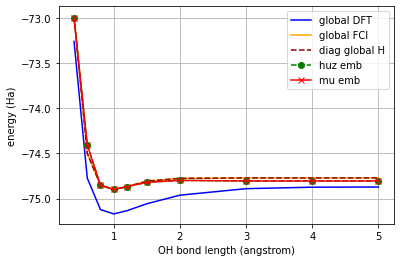

In [20]:
%matplotlib inline

R_list =  [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(R_list, global_dft_list, label='global DFT', color='b')
plt.plot(R_list, global_fci_list, label='global FCI', color='orange')
plt.plot(R_list, global_fci_list, label='diag global H', linestyle='dashed', color='darkred')
plt.plot(R_list, huz_H_diag_list, label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(R_list, mu_H_diag_list, label='mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('OH bond length (angstrom)')
plt.ylabel('energy (Ha)')
plt.grid(True)
plt.legend()
# plt.savefig("test_energy.png", dpi=300)
plt.show()

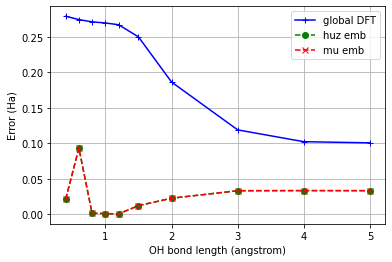

In [21]:
%matplotlib inline

R_list =  [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(R_list, abs(np.array(global_dft_list) - np.array(global_fci_list)), label='global DFT', color='b', marker='+')
plt.plot(R_list, abs(np.array(huz_H_diag_list) - np.array(global_fci_list)), label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(R_list, abs(np.array(mu_H_diag_list) - np.array(global_fci_list)), label='mu emb', linestyle='--', marker='x', color='r')

plt.xlabel('OH bond length (angstrom)')
plt.ylabel('Error (Ha)')
plt.grid(True)
plt.legend()
# plt.savefig("test_error.png", dpi=300)
plt.show()

In [22]:
# order by R_length

list_files_nonstretch = [ filename for filename in os.listdir(structure_dir) if filename.startswith('act_nonstretch_H2O')]

all_xyz_files_nonstretch = sorted(list_files_nonstretch, 
                       key=lambda text: int(text.partition("H2O_")[2].partition(".xyz")[0]))


list_file_paths_nonstretch = []
for xyz_filename in all_xyz_files_nonstretch:
    list_file_paths_nonstretch.append(os.path.join(structure_dir, xyz_filename))
list_file_paths_nonstretch

['/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_4.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_6.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_7.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_10.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_12.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_15.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_20.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_30.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/act_nonstretch_H2O_40.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_cor

In [72]:

for geometry_path in tqdm(list_file_paths_nonstretch):
    
    ########## CHANGED!!!
    #find number of DD in last part of xyz string: aka DD.xyz 
    bond = int(re.findall(r'\d+',geometry_path[95:])[0])
    if bond<=10:
        occupied_threshold = 0.95
        print(bond, occupied_threshold)
    else:
        occupied_threshold = 0.9
        print(bond, occupied_threshold)

  0%|          | 0/10 [00:00<?, ?it/s]

4 0.95
6 0.95
7 0.95
10 0.95
12 0.9
15 0.9
20 0.9
30 0.9
40 0.9
50 0.9


In [53]:
import re
## NOTE CHANGE THRESHOLD DEPENDING ON BOND LENGTH!

global_dft_list2=[]
global_fci_list2=[]
global_H_diag_list2=[]
global_qubit_H_length_list2=[]
global_qubit_H_nqubits2=[]
global_H2 = []

huz_rhf_list2=[]
huz_ccsd_list2=[]
huz_fci_list2=[]
huz_H_diag_list2=[]
huz_qubit_H_length_list2=[]
huz_H_nqubits2=[]
huz_embed_H2 = []

mu_rhf_list2=[]
mu_ccsd_list2=[]
mu_fci_list2=[]
mu_H_diag_list2=[]
mu_qubit_H_length_list2=[]
mu_H_nqubits2=[]
mu_embed_H2 = []

N_active_MOs2 = []


for geometry_path in tqdm(list_file_paths_nonstretch):
    
    ########## CHANGED!!!
    #find number of DD in last part of xyz string: aka DD.xyz 
    bond = int(re.findall(r'\d+',geometry_path[95:])[0])
    if bond<=10:
        occupied_threshold = 0.95
    else:
        occupied_threshold = 0.9
    ########## CHANGED!!!
    
    
    driver = NbedDriver(
            geometry=geometry_path,
            n_active_atoms=n_active_atoms,
            basis=basis,
            xc_functional=xc_functional,
            projector=projector,
            localization=localization,
            convergence=convergence,
            charge=charge,
            mu_level_shift=mu_level_shift,
            run_ccsd_emb=run_ccsd_emb,
            run_fci_emb=run_fci_emb,
            max_ram_memory=max_ram_memory,
            pyscf_print_level=pyscf_print_level,
            unit=unit,
            occupied_threshold=occupied_threshold,
            virtual_threshold=virtual_threshold,
            max_hf_cycles=max_hf_cycles,
            max_dft_cycles=max_dft_cycles,
            _init_huzinaga_rhf_with_mu = init_huzinaga_rhf_with_mu)


    ## global
    global_dft_list2.append(driver._global_rks.e_tot)
    global_fci_list2.append(driver._global_fci.e_tot)
    
    global_qubit_Ham = get_hamiltonian_from_driver(driver._global_hf,
                                           driver._global_hf.energy_nuc(), 
                                           transform)
    global_H2.append(global_qubit_Ham)
    global_H_sparse = get_sparse_operator(global_qubit_Ham)
    E_fci =  sp.sparse.linalg.eigsh(global_H_sparse, k=1, which='SA')[0][0] 
    global_H_diag_list2.append(E_fci)

    global_qubit_H_length_list2.append(len(global_qubit_Ham.terms))
    global_qubit_H_nqubits2.append(count_qubits(global_qubit_Ham))

    ##
    N_active_MOs2.append(len(driver.localized_system.active_MO_inds))
    
    # HUZ
    huz_rhf_list2.append(driver._huzinaga['e_rhf'])
    huz_ccsd_list2.append(driver._huzinaga['e_ccsd'])
    huz_fci_list2.append(driver._huzinaga['e_fci'])

    huz_classical = driver._huzinaga['classical_energy']
    huz_qubit_Ham = get_hamiltonian_from_driver(driver._huzinaga["scf"],
                                        huz_classical, #+ driver._huzinaga["scf"].energy_nuc(), 
                                        transform)
    
    huz_H_sparse = get_sparse_operator(huz_qubit_Ham)
    huz_e_emb = sp.sparse.linalg.eigsh(huz_H_sparse, k=1, which='SA')[0][0]
    huz_H_diag_list2.append(huz_e_emb)

    huz_qubit_H_length_list2.append(len(huz_qubit_Ham.terms))
    huz_nqubits = count_qubits(huz_qubit_Ham)
    huz_H_nqubits2.append(huz_nqubits)
    huz_embed_H2.append(huz_qubit_Ham)

    # mu shift
    mu_rhf_list2.append(driver._mu['e_rhf'])
    mu_ccsd_list2.append(driver._mu['e_ccsd'])
    mu_fci_list2.append(driver._mu['e_fci'])
    
    mu_classical = driver._mu['classical_energy']
    mu_qubit_Ham = get_hamiltonian_from_driver(driver._mu["scf"],
                                        mu_classical, #+ driver._mu["scf"].energy_nuc(), 
                                        transform)
    
    mu_H_sparse = get_sparse_operator(mu_qubit_Ham)
    mu_e_emb = sp.sparse.linalg.eigsh(mu_H_sparse, k=1, which='SA')[0][0]
    mu_H_diag_list2.append(mu_e_emb)
    
    mu_nqubits = count_qubits(mu_qubit_Ham)
    mu_qubit_H_length_list2.append(len(mu_qubit_Ham.terms))
    mu_H_nqubits2.append(mu_nqubits)
    mu_embed_H2.append(mu_qubit_Ham)
    
    del driver



  0%|          | 0/10 [00:00<?, ?it/s]

 Iterative localization: IB/P4/2x2, 5 iter; Final gradient 1.46e-12
 Iterative localization: IB/P4/2x2, 6 iter; Final gradient 1.27e-09
 Iterative localization: IB/P4/2x2, 5 iter; Final gradient 3.30e-09
 Iterative localization: IB/P4/2x2, 5 iter; Final gradient 5.67e-10
 Iterative localization: IB/P4/2x2, 6 iter; Final gradient 5.06e-10
 Iterative localization: IB/P4/2x2, 6 iter; Final gradient 6.03e-10
 Iterative localization: IB/P4/2x2, 6 iter; Final gradient 1.01e-10
 Iterative localization: IB/P4/2x2, 5 iter; Final gradient 3.12e-12
 Iterative localization: IB/P4/2x2, 4 iter; Final gradient 2.60e-10
 Iterative localization: IB/P4/2x2, 3 iter; Final gradient 5.58e-09


In [54]:
exp_data2 = {
    'global DFT': global_dft_list2, 
    
    'global FCI': global_fci_list2,
    'huz emb FCI': huz_H_diag_list2,
    'mu emb FCI': mu_H_diag_list2,
    
    'global H': global_qubit_H_length_list2,
    'huz H emb': huz_qubit_H_length_list2,
    'mu H emb': mu_qubit_H_length_list2,
    
    'global n qubits': global_qubit_H_nqubits2,
    'huz n qubits': huz_H_nqubits2,
    'mu n qubits': mu_H_nqubits2,
    'N active MOs': N_active_MOs2,
    
}

df2 = pd.DataFrame(data=exp_data2)

df2

,global DFT,global FCI,huz emb FCI,mu emb FCI,global H,huz H emb,mu H emb,global n qubits,huz n qubits,mu n qubits,N active MOs
0,-73.259936,-72.981056,-73.002213,-73.002218,2110,1079,1079,14,12,12,4
1,-74.773419,-74.499220,-74.519666,-74.519669,2110,1079,1079,14,12,12,4
2,-75.122053,-74.851089,-74.852614,-74.852616,1086,1079,1079,14,12,12,4
3,-75.170068,-74.900658,-74.927934,-74.927935,2110,1079,1079,14,12,12,4
4,-75.134418,-74.867498,-74.911230,-74.911230,2110,1079,1079,14,12,12,4
5,-75.057384,-74.807539,-74.847007,-74.847007,2110,1079,1079,14,12,12,4
6,-74.962535,-74.776263,-74.755515,-74.755515,2110,1079,1079,14,12,12,4
7,-74.890578,-74.771692,-74.683923,-74.683923,2494,1205,1363,14,12,12,4
8,-74.874152,-74.771719,-74.667458,-74.667458,3362,1095,1103,14,12,12,4
9,-74.872308,-74.771718,-74.665599,-74.665599,3054,1775,1799,14,12,12,4


In [55]:
csv_filename2 = 'nonactive_OH_stretch_results_IBO_threshold_lowered.csv' 
df2.to_csv(os.path.join(current_dir, csv_filename2), index=False)

In [56]:
exp_data2['bond_length'] =  [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]
exp_data2['global_H'] = [HamiltonianConverter(H)._intermediate for H in global_H2]
exp_data2['huz_embed_H'] = [HamiltonianConverter(H)._intermediate for H in huz_embed_H2]
exp_data2['mu_embed_H'] = [HamiltonianConverter(H)._intermediate for H in mu_embed_H2]


In [72]:
df2.keys()

Index(['global DFT', 'global FCI', 'huz emb FCI', 'mu emb FCI', 'global H',
       'huz H emb', 'mu H emb', 'global n qubits', 'huz n qubits',
       'mu n qubits', 'N active MOs'],
      dtype='object')

In [57]:
# import results
csv_filename2 = 'nonactive_OH_stretch_results_IBO_threshold_lowered.csv'
df2 = pd.read_csv(os.path.join(current_dir, csv_filename2))

global_dft_list2 = np.array(df2['global DFT'])

global_fci_list2 = np.array(df2['global FCI'])
huz_H_diag_list2 = np.array(df2['huz emb FCI'])
mu_H_diag_list2 = np.array(df2['mu emb FCI'])

global_qubit_H_length_list2 = np.array(df2['global H'])
huz_qubit_H_length_list2 = np.array(df2['huz H emb'])
mu_qubit_H_length_list2 = np.array(df2['mu H emb'])

global_qubit_H_nqubits2 = np.array(df2['global n qubits'])
huz_H_nqubits2 = np.array(df2['huz n qubits'])
mu_H_nqubits2 = np.array(df2['mu n qubits'])
N_active_MOs2 = np.array(df2['N active MOs'])


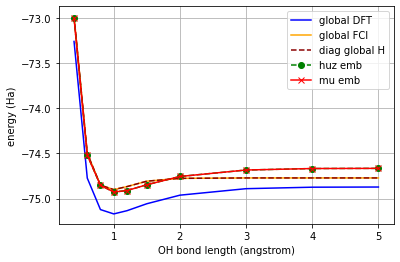

In [58]:
%matplotlib inline

R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(R_list, global_dft_list2, label='global DFT', color='b')
plt.plot(R_list, global_fci_list2, label='global FCI', color='orange')
plt.plot(R_list, global_fci_list2, label='diag global H', linestyle='dashed', color='darkred')
plt.plot(R_list, huz_H_diag_list2, label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(R_list, mu_H_diag_list2, label='mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('OH bond length (angstrom)')
plt.ylabel('energy (Ha)')
plt.grid(True)
plt.legend()
# plt.savefig("test_energy2.png", dpi=300)
plt.show()

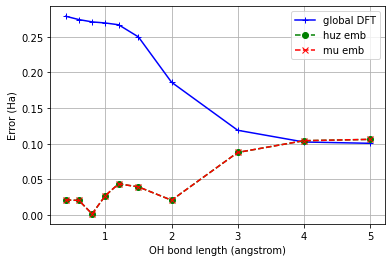

In [59]:
%matplotlib inline

R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(R_list, abs(np.array(global_dft_list2) - np.array(global_fci_list2)), label='global DFT', color='b', marker='+')
plt.plot(R_list, abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)), label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(R_list, abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)), label='mu emb', linestyle='--', marker='x', color='r')

plt.xlabel('OH bond length (angstrom)')
plt.ylabel('Error (Ha)')
plt.grid(True)
plt.legend()
# plt.savefig("test_error2.png", dpi=300)
plt.show()

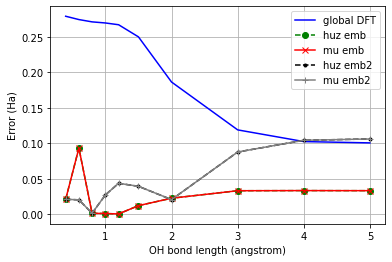

In [60]:
%matplotlib inline

R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(R_list, abs(np.array(global_dft_list2) - np.array(global_fci_list)), label='global DFT', color='b')
plt.plot(R_list, abs(np.array(huz_H_diag_list) - np.array(global_fci_list)), label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(R_list, abs(np.array(mu_H_diag_list) - np.array(global_fci_list)), label='mu emb', linestyle='-', marker='x', color='r')

plt.plot(R_list, abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)), label='huz emb2', linestyle='dashed', marker='.', color='k')
plt.plot(R_list, abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)), label='mu emb2', linestyle='-', marker='+', color='grey')


plt.xlabel('OH bond length (angstrom)')
plt.ylabel('Error (Ha)')
plt.grid(True)
plt.legend()
# plt.savefig("test_error.png", dpi=300)
plt.show()

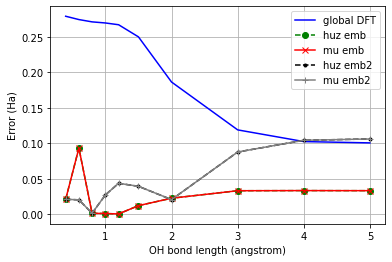

In [61]:
%matplotlib inline

R_list = [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]


plt.plot(R_list, abs(np.array(global_dft_list2) - np.array(global_fci_list)), label='global DFT', color='b')
plt.plot(R_list, abs(np.array(huz_H_diag_list) - np.array(global_fci_list)), label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(R_list, abs(np.array(mu_H_diag_list) - np.array(global_fci_list)), label='mu emb', linestyle='-', marker='x', color='r')

plt.plot(R_list, abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2)), label='huz emb2', linestyle='dashed', marker='.', color='k')
plt.plot(R_list, abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2)), label='mu emb2', linestyle='-', marker='+', color='grey')


plt.xlabel('OH bond length (angstrom)')
plt.ylabel('Error (Ha)')
plt.grid(True)
plt.legend()
# plt.savefig("test_error.png", dpi=300)
plt.show()

In [62]:
np.array(global_dft_list2) - np.array(global_dft_list)

array([ 0.00000000e+00, -2.84217094e-14,  2.84217094e-14,  1.42108547e-14,
       -5.68434189e-14, -7.10542736e-14,  1.56319402e-13,  1.03565942e-06,
       -1.73405605e-04,  7.38191089e-05])

https://www.ucl.ac.uk/cam/brand/guidelines/colour

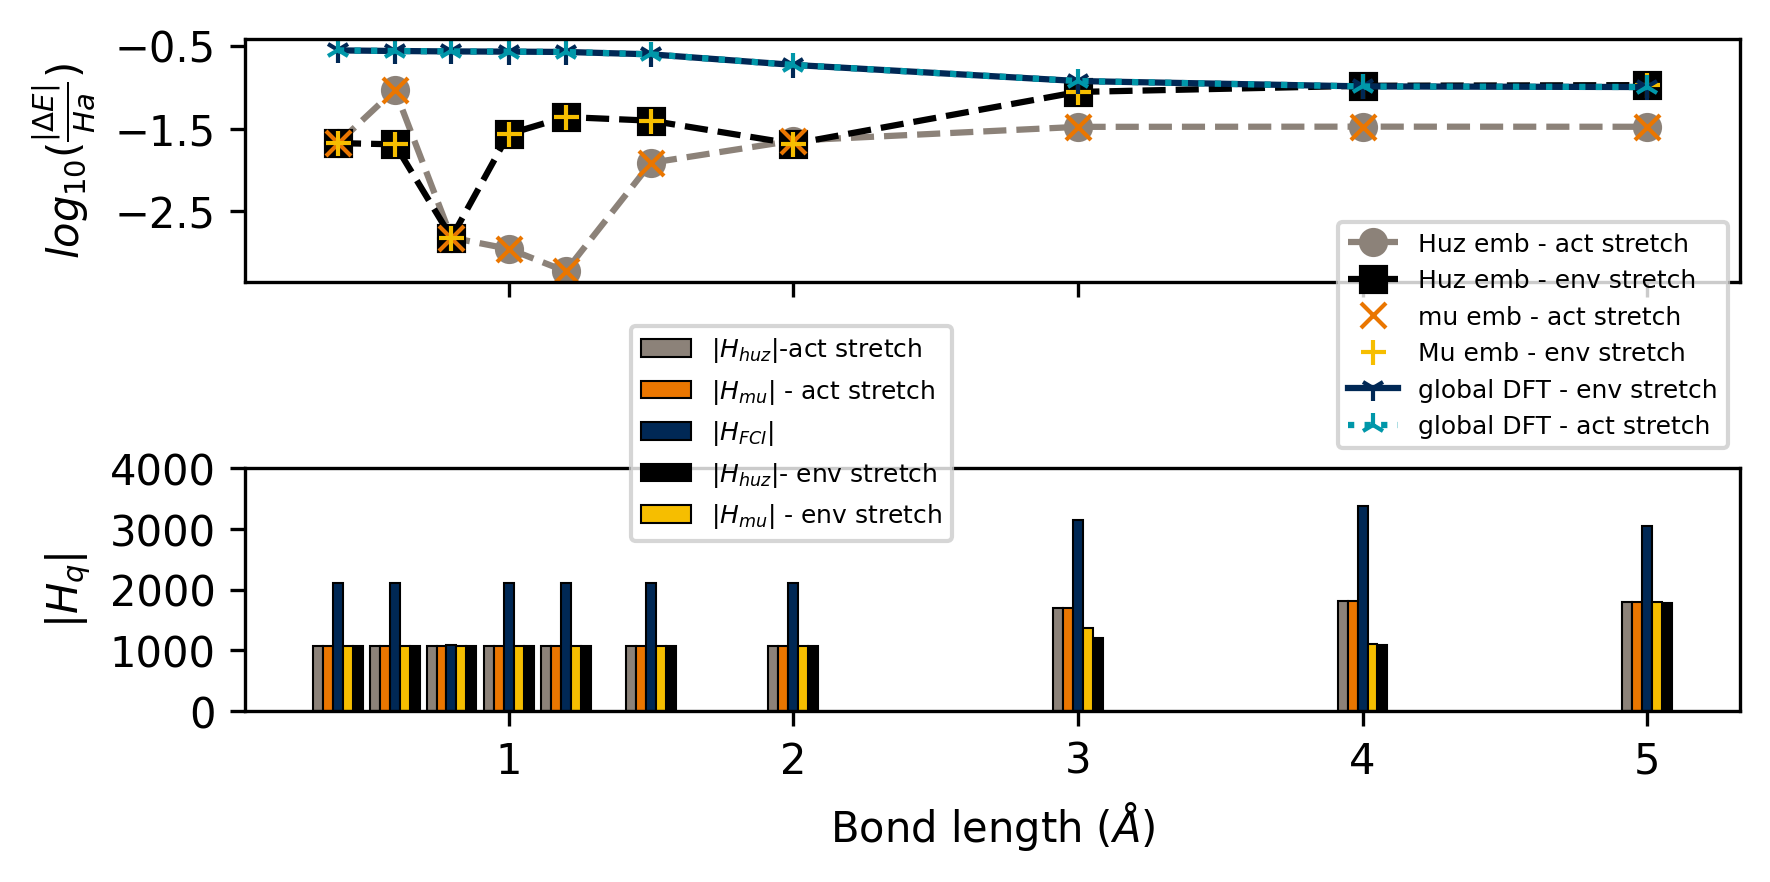

In [63]:
fig = plt.figure(dpi=300)

gs = fig.add_gridspec(3,2)

ax1 = fig.add_subplot(gs[0,:])# goes over both columns!
ax2 = fig.add_subplot(gs[1,:])
# ax3 = fig.add_subplot(gs[1,1])

# colour_stone = '#C0BDB0' #'#D6D2C4'
# colour_dark_brown = '#4E3629'

# colour_stone = '#500778' 
# colour_dark_brown = '#AC145A'

colour_stone = '#8C8279' 
colour_dark_brown = 'k'#'#47423e'

colour_midblue = '#002855'
colour_brightblue = '#0097A9'

colour_orange = '#EA7600'
colour_dark_yellow = '#F6BE00'

FCI_colour = '#002855'


ax1.plot(R_list,np.log10(abs(np.array(huz_H_diag_list) - np.array(global_fci_list))), label='Huz emb - act stretch', marker='o',
         color=colour_stone, linestyle='dashed')
ax1.plot(R_list,np.log10(abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2))), label='Huz emb - env stretch', marker='s', 
         color=colour_dark_brown, linestyle='dashed')
ax1.plot(R_list,np.log10(abs(np.array(mu_H_diag_list) - np.array(global_fci_list))), label='mu emb - act stretch', marker='x', 
         color=colour_orange,linestyle='')
ax1.plot(R_list, np.log10(abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2))), label='Mu emb - env stretch', marker='+', 
         color=colour_dark_yellow, linestyle='')

ax1.plot(R_list,np.log10(abs(np.array(global_dft_list2) - np.array(global_fci_list2))), label='global DFT - env stretch', 
         color=colour_midblue, marker='1')
ax1.plot(R_list,np.log10(abs(np.array(global_dft_list) - np.array(global_fci_list))), label='global DFT - act stretch', 
         color=colour_brightblue, marker='2', linestyle='dotted')


# ax1.legend(loc="upper right", fontsize =5)

# ax1.set_ylabel('energy error (Ha)')
ax1.set_ylabel(r'$log_{10}(\frac{|\Delta E|}{Ha})$')
# ax1.set_xlabel(r'Bond length ($\AA$)')
ax1.set_xticklabels([])


# First result - number of terms
wid = 0.035

ax2.bar(np.array(R_list)-2*wid, huz_qubit_H_length_list, width=wid, color=colour_stone, align='center', label='$|H_{huz}|$-act stretch', edgecolor='k', linewidth=0.5)
ax2.bar(np.array(R_list)-wid, mu_qubit_H_length_list, width=wid, color=colour_orange, align='center', label='$|H_{mu}|$ - act stretch', edgecolor='k', linewidth=0.5)
ax2.bar(np.array(R_list), global_qubit_H_length_list, width=wid, color=FCI_colour, align='center', label='$|H_{FCI}|$', edgecolor='k', linewidth=0.5)
ax2.set_ylabel(r'$|H_{q}|$')
ax2.set_xlabel(r'Bond length ($\AA$)')

ax2.bar(np.array(R_list)+2*wid, huz_qubit_H_length_list2, width=wid, color=colour_dark_brown, align='center', label='$|H_{huz}|$- env stretch', edgecolor='k', linewidth=0.5)
ax2.bar(np.array(R_list)+wid, mu_qubit_H_length_list2, width=wid, color=colour_dark_yellow, align='center', label='$|H_{mu}|$ - env stretch', edgecolor='k', linewidth=0.5)
ax2.set_xlabel(r'Bond length ($\AA$)')

# shared x axis
ax1.get_shared_x_axes().join(ax1, ax2)

# set axis limits
# ax1.yaxis.set_ticks(np.arange(0, 0.4, 0.1))
ax1.yaxis.set_ticks(np.arange(-2.5, 0, 1))
ax2.yaxis.set_ticks(np.arange(0, 5000, 1000))

plt.tight_layout()
# ax1.legend(bbox_to_anchor=(0.7, 0.5, 0.5, 0.5), fontsize=6)
ax1.legend(bbox_to_anchor=(0.5, -0.2, 0.5, 0.5), fontsize=6)
ax2.legend(bbox_to_anchor=(0.25, 0.65, 0.5, 0.5), fontsize=6)

fig.savefig('water_correlated_results_IBO_threshold_lowered.png', bbox_inches = 'tight')
plt.show()


In [64]:


R_list =  [0.4, 0.6, 0.7989538439284714, 1, 1.2, 1.5, 2, 3, 4, 5]

error_DFT = abs(np.array(global_dft_list) - np.array(global_fci_list))
error_HUZ = abs(np.array(huz_H_diag_list) - np.array(global_fci_list))
error_MU = abs(np.array(mu_H_diag_list) - np.array(global_fci_list))



In [65]:
plot_data_1 = {
    'OH length': R_list,
    'error DFT': error_DFT, 
    'error HUZ': error_HUZ,
    'error mu': error_MU,
    
    'Hfull': global_qubit_H_length_list,
    'Hhuz': huz_qubit_H_length_list,
    'Hmu': mu_qubit_H_length_list,
    
    'global n qubits': global_qubit_H_nqubits,
    'huz n qubits': huz_H_nqubits,
    'mu n qubits': mu_H_nqubits,
    'N active MOs': N_active_MOs,
}

df_data1= pd.DataFrame(data=plot_data_1)
df_data1

,OH length,error DFT,error HUZ,error mu,Hfull,Hhuz,Hmu,global n qubits,huz n qubits,mu n qubits,N active MOs
0,0.400000,0.278880,0.021158,0.021162,2110,1079,1079,14,12,12,4
1,0.600000,0.274200,0.093226,0.093222,2110,1079,1079,14,12,12,4
2,0.798954,0.270965,0.001525,0.001527,1086,1079,1079,14,12,12,4
3,1.000000,0.269410,0.001118,0.001115,2110,1079,1079,14,12,12,4
4,1.200000,0.266920,0.000598,0.000601,2110,1079,1079,14,12,12,4
5,1.500000,0.249844,0.012237,0.012239,2110,1079,1079,14,12,12,4
6,2.000000,0.186272,0.022689,0.022691,2110,1079,1079,14,12,12,4
7,3.000000,0.118892,0.033247,0.033249,3146,1699,1699,14,12,12,4
8,4.000000,0.102260,0.033436,0.033438,3374,1815,1815,14,12,12,4
9,5.000000,0.100664,0.033319,0.033322,3046,1795,1795,14,12,12,4


In [41]:
print(df_data1.to_latex(index=False))

\begin{tabular}{rrrrrrrrrrr}
\toprule
 OH length &  error DFT &  error HUZ &  error mu &  Hfull &  Hhuz &  Hmu &  global n qubits &  huz n qubits &  mu n qubits &  N active MOs \\
\midrule
  0.400000 &   0.278880 &   0.052514 &  0.058005 &   2110 &   492 &  492 &               14 &            10 &           10 &             3 \\
  0.600000 &   0.274200 &   0.014675 &  0.014669 &   2110 &   492 &  492 &               14 &            10 &           10 &             3 \\
  0.798954 &   0.270965 &   0.001525 &  0.001527 &   1086 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  1.000000 &   0.269410 &   0.001118 &  0.001115 &   2110 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  1.200000 &   0.266920 &   0.000598 &  0.000601 &   2110 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  1.500000 &   0.249844 &   0.012237 &  0.012239 &   2110 &  1079 & 1079 &               14 &        

In [66]:
error_DFT2 = abs(np.array(global_dft_list2) - np.array(global_fci_list2))
error_HUZ2 = abs(np.array(huz_H_diag_list2) - np.array(global_fci_list2))
error_MU2 = abs(np.array(mu_H_diag_list2) - np.array(global_fci_list2))


plot_data_2 = {
    'OH length': R_list,
    'error DFT': error_DFT2, 
    'error HUZ': error_HUZ2,
    'error mu': error_MU2,
    
    'Hfull': global_qubit_H_length_list2,
    'Hhuz': huz_qubit_H_length_list2,
    'Hmu': mu_qubit_H_length_list2,
    
    'global n qubits': global_qubit_H_nqubits2,
    'huz n qubits': huz_H_nqubits2,
    'mu n qubits': mu_H_nqubits2,
    'N active MOs': N_active_MOs2,
}

df_data2= pd.DataFrame(data=plot_data_2)
df_data2

,OH length,error DFT,error HUZ,error mu,Hfull,Hhuz,Hmu,global n qubits,huz n qubits,mu n qubits,N active MOs
0,0.400000,0.278880,0.021158,0.021162,2110,1079,1079,14,12,12,4
1,0.600000,0.274200,0.020446,0.020449,2110,1079,1079,14,12,12,4
2,0.798954,0.270965,0.001525,0.001527,1086,1079,1079,14,12,12,4
3,1.000000,0.269410,0.027276,0.027277,2110,1079,1079,14,12,12,4
4,1.200000,0.266920,0.043732,0.043733,2110,1079,1079,14,12,12,4
5,1.500000,0.249844,0.039467,0.039468,2110,1079,1079,14,12,12,4
6,2.000000,0.186272,0.020748,0.020748,2110,1079,1079,14,12,12,4
7,3.000000,0.118886,0.087769,0.087769,2494,1205,1363,14,12,12,4
8,4.000000,0.102433,0.104260,0.104260,3362,1095,1103,14,12,12,4
9,5.000000,0.100590,0.106120,0.106120,3054,1775,1799,14,12,12,4


In [67]:
print(df_data2.to_latex(index=False))

\begin{tabular}{rrrrrrrrrrr}
\toprule
 OH length &  error DFT &  error HUZ &  error mu &  Hfull &  Hhuz &  Hmu &  global n qubits &  huz n qubits &  mu n qubits &  N active MOs \\
\midrule
  0.400000 &   0.278880 &   0.021158 &  0.021162 &   2110 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  0.600000 &   0.274200 &   0.020446 &  0.020449 &   2110 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  0.798954 &   0.270965 &   0.001525 &  0.001527 &   1086 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  1.000000 &   0.269410 &   0.027276 &  0.027277 &   2110 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  1.200000 &   0.266920 &   0.043732 &  0.043733 &   2110 &  1079 & 1079 &               14 &            12 &           12 &             4 \\
  1.500000 &   0.249844 &   0.039467 &  0.039468 &   2110 &  1079 & 1079 &               14 &        

In [68]:
##
pickle_dir = os.path.join(current_dir, "pickle_output")
# os.makedirs(pickle_dir)

In [69]:
fname = 'active_stretch_IBO_threshold_lowered'
fpath = os.path.join(pickle_dir, fname+'.pickle')
with open(fpath, 'wb') as fp:
    pickle.dump(exp_data, fp)

In [70]:
fname2 = 'enviro_stretch_IBO_threshold_lowered'
fpath2 = os.path.join(pickle_dir, fname2+'.pickle')
with open(fpath2, 'wb') as fp:
    pickle.dump(exp_data2, fp)